# simple regression

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from hyperopt import hp, tpe, Trials, fmin
import optuna
%matplotlib inline
# from utils import data_process as dp

In [2]:
input_dir = '../input/'
working_dir = '../working/'
output_dir = '../output/'

## Read data

In [3]:
sleeper_type_dict = {
    1: 'pc',
    2: 'wooden',
    3: 'junction',
    4: 'short',
    5: 'synthetic',
    6: 'synth_junc',
    7: 'symth_short',
    8: 'other'
}

In [4]:
def read_track(line_name='a'):
    track_df = pd.read_csv(os.path.join(input_dir, 'track_{}.csv'.format(line_name.upper())))
    col_names_track = ['date', 'kilo', 'lev_l', 'lev_r', 'cur_l', 'cur_r', 'cant', 'width', 'speed']
    track_df.columns = col_names_track
    track_df['date'] = pd.to_datetime(track_df['date'])
    track_df['kilo'] = track_df['kilo'].astype('str')
    print('track_{line_name} shape: {shape}'.format(line_name=line_name.upper(), shape=track_df.shape))
    return track_df

In [5]:
abcd = 'b'

In [6]:
track = read_track(abcd)

track_B shape: (7815753, 9)


In [7]:
# sample_submit = pd.read_csv(os.path.join(input_dir, 'sample_submit.csv'), header=None)
index_master = pd.read_csv(os.path.join(input_dir, 'index_master.csv'))
index_master.columns = ['id', 'line_name', 'date', 'kilo']
index_master['date'] = pd.to_datetime(index_master['date'])
index_master['kilo'] = index_master['kilo'].astype('str')

## Data Processing

In [8]:
# Drop outliers of diff to exclude maintenance effect (out of 2 sigma for each kilo)
# If line_name is "A", also drop outliers of lev_l
def outlier_filter(track):
    lev_pv = track.pivot(index='date', columns='kilo', values='lev_l')
    lev_pv.columns = lev_pv.columns.astype('str')
    lev_pv_diff = lev_pv.diff()

    lev_pv_diff_norm = (lev_pv_diff - lev_pv_diff.mean()) / lev_pv_diff.std()
    lev_pv_diff_norm_isnot_outlier = lev_pv_diff_norm.abs() < 2
    if abcd=='a':
        lev_pv_norm = (lev_pv - lev_pv.mean()) / lev_pv.std()
        lev_pv_norm_isnot_outlier = lev_pv_norm.abs() < 2
        lev_pv_diff_norm_isnot_outlier *= lev_pv_norm_isnot_outlier
    lev_pv_filtered_tmp = lev_pv * lev_pv_diff_norm_isnot_outlier
    lev_pv_filtered = lev_pv_filtered_tmp.replace(0.0, np.nan)
    lev_filtered = pd.melt(lev_pv_filtered.reset_index(), id_vars='date', value_name='lev_l')  
    track_new = lev_filtered.merge(track.drop('lev_l', axis=1), how='left', on=['date', 'kilo'])
    return track_new

In [9]:
track = outlier_filter(track)

/home/kuriyama/miniconda3/envs/rail_level_gap/lib/python3.6/site-packages/pandas/core/nanops.py:358: RuntimeWarning: divide by zero encountered in true_divide
  the_mean = the_sum / count


In [10]:
def calc_diff_mean(track_tgt_prd):
    track_tgt_prd_pv = track_tgt_prd.pivot(index='date', columns='kilo', values='lev_l')
    track_tgt_prd_pv.columns = track_tgt_prd_pv.columns.astype('str')
    track_tgt_prd_pv_diff = track_tgt_prd_pv.diff()
    return track_tgt_prd_pv_diff.mean()

In [11]:
track_tgt_diff_mean = calc_diff_mean(track.query('date<"2017-07-01"'))

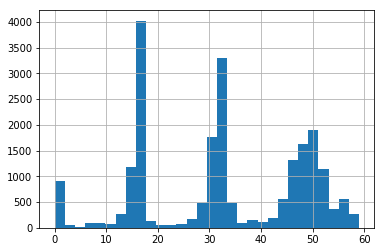

In [12]:
track.query('date<"2017-07-01"').pivot(index='date', columns='kilo', values='lev_l').count().hist(bins=30)

### rolling average, diff

In [13]:
# rolling average params
roll_params = {
    'A': {'window': 21, 'min_periods': 14},
    'B': {'window': 14, 'min_periods': 7},
    'C': {'window': 14, 'min_periods': 7},
    'D': {'window': 14, 'min_periods': 7}
}

In [14]:
def roll_pv(track, abcd):
    # pivot: row is date, col is kilo
    lev_pv = track.pivot(index='date', columns='kilo', values='lev_l')
    lev_pv.columns = lev_pv.columns.astype('str')
    # rolling average
    lev_pv_ra = lev_pv.rolling(**roll_params[abcd.upper()], center=False, axis=0).mean()
    return lev_pv_ra

In [15]:
lev_pv_ra = roll_pv(track, abcd)

上で計算した差分の平均を一日ごとに加算していきたいが、それぞれのキロによって最後の観測日が異なるので加算する回数もそれぞれ変えなければならない
まず、それぞれのキロでSeriseを作りNULLの行を削除することで最後の観測日を入手。その日付から4月1日までの日数を計算。
※最終観測日が異常に古いORそもそも一回の観測されていないようなキロについては隣接するキロの数値をそのままコピーする

In [16]:
index_master_abcd = index_master.query('line_name=="{}"'.format(abcd.upper()))
tgt_date_s = index_master_abcd.query('kilo=="10000"')['date']
pred_pv = pd.DataFrame(data=np.nan, index=tgt_date_s, columns=lev_pv_ra.columns)

In [17]:
def pred_by_col(track_kilo_i):
    # need adaquate samples
    if track_kilo_i.count() > 40:
        kilo_i = track_kilo_i.name
        last_date_lev_l_kilo_i = track_kilo_i.dropna().tail(1)
        # skip when the last date is too old
        if last_date_lev_l_kilo_i.index > datetime.datetime(2018, 3, 1):
            base_date_cnt = np.array(range(91)) + 1
            add_date_cnt = datetime.datetime(2018, 3, 31) - last_date_lev_l_kilo_i.index
            date_cnt = base_date_cnt + add_date_cnt.days.tolist()
            pred_arr = date_cnt * track_tgt_diff_mean[str(kilo_i)]
            pred_pv[str(kilo_i)] = pred_arr
            last_date_values.append(last_date_lev_l_kilo_i.values)
            diff_means.append(track_tgt_diff_mean[str(kilo_i)])

In [18]:
last_date_values = []
diff_means = []

In [19]:
lev_pv_ra.apply(pred_by_col)
print('')

In [20]:
len(last_date_values)

14863

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f537f20a320>]],
      dtype=object)

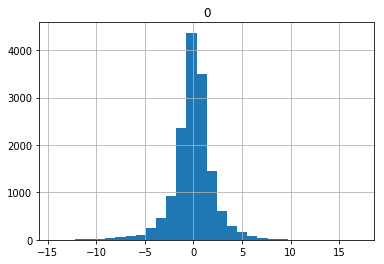

In [21]:
pd.DataFrame(last_date_values).hist(bins=30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f537d899ac8>]],
      dtype=object)

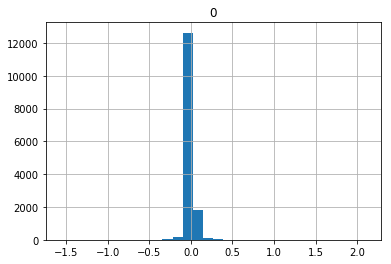

In [22]:
pd.DataFrame(diff_means).hist(bins=30)

予測最終日の値が異常値な場合はそのキロを削除する  
trackのlev_lの5σの外側の値だった場合に異常値とする

In [23]:
track['lev_l'].std()
lev_l_uplim = track['lev_l'].mean() + track['lev_l'].std() * 5
lev_l_lowlim = track['lev_l'].mean() - track['lev_l'].std() * 5

In [24]:
is_in_sigma = (pred_pv.tail(1) < lev_l_uplim) & (pred_pv.tail(1) > lev_l_lowlim)
is_out_sigma = ~is_in_sigma
is_out_sigma_cols = pred_pv.columns[is_out_sigma.values.reshape(-1)]
pred_pv[is_out_sigma_cols] = np.nan

In [25]:
pred_pv.head(1).isnull().sum().sum()

7194

In [26]:
pred_pv.shape

(91, 21531)

In [27]:
lev_l_uplim

10.506762077238223

In [28]:
pred_pv_filled = pred_pv.copy()
for i in range(100):
    pred_pv_filled = pred_pv_filled.fillna(method='ffill', axis=1, limit=1)
    pred_pv_filled = pred_pv_filled.fillna(method='bfill', axis=1, limit=1)
    
pred_pv_filled = pred_pv_filled.fillna(method='ffill', axis=1)
pred_pv_filled = pred_pv_filled.fillna(method='bfill', axis=1)

In [29]:
pred_filled = pd.melt(pred_pv_filled.reset_index(), id_vars='date', value_name='lev_l_pred')  

In [30]:
pred_df = index_master_abcd.merge(pred_filled, how='left', on=['date', 'kilo'])
pred_df = pred_df.rename(columns={'lev_l': 'lev_l_pred'})
pred_df = pred_df.drop('id', axis=1)

In [31]:
pred_df.to_csv(os.path.join(output_dir, 'simple_regression_20190106_{}.csv'.format(abcd.upper())), index=False)

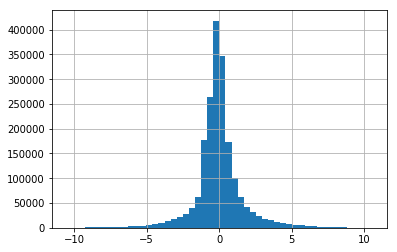

In [32]:
pred_df['lev_l_pred'].hist(bins=50)

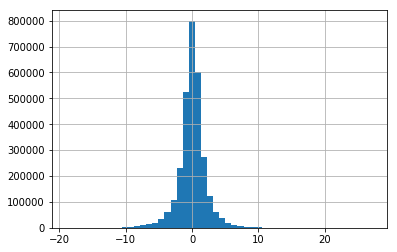

In [33]:
track['lev_l'].hist(bins=50)